<a href="https://colab.research.google.com/github/SarthakNP/GAN_Fashion_prediction_model/blob/main/GAN_Project_Fashion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset and libraries**

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import ipywidgets
import numpy as np


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [3]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.WYXS24_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.WYXS24_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [4]:
ds.as_numpy_iterator().next()['label']

2

# **Visualize Data and Build Dataset**

In [5]:
dataIterator = ds.as_numpy_iterator()
#get data from dataset
dataIterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

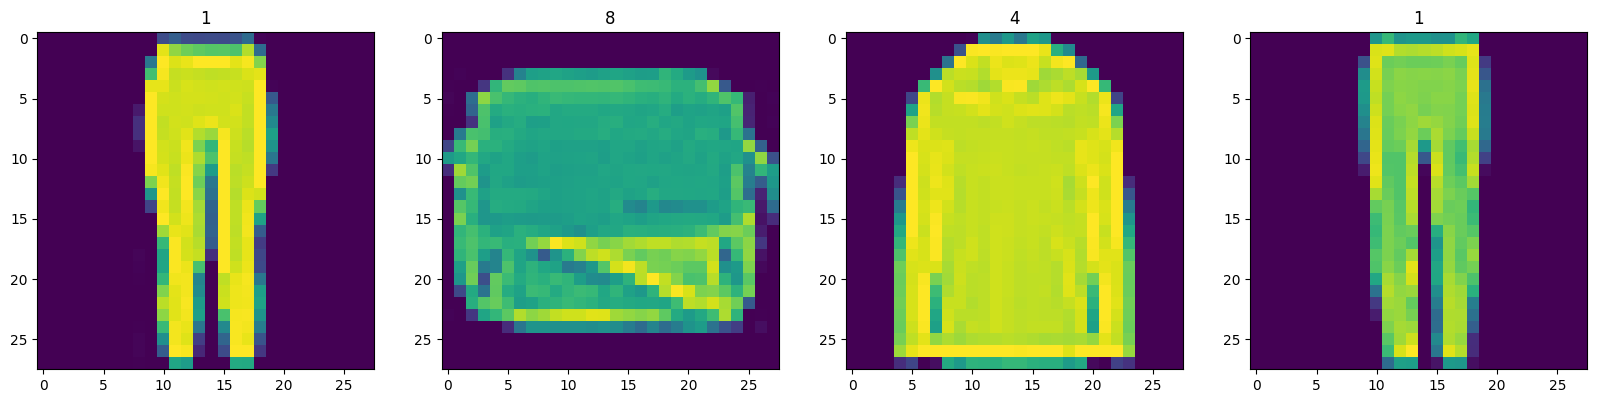

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample = dataIterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [7]:
#scale and return image only
def scale_images(data):
    image = data['image']
    return image/255

In [8]:
#reload the dataset (optional)
ds = tfds.load('fashion_mnist', split='train')
# runnning the dataset through the sclae_images preprocessing step
ds = ds.map(scale_images)
# caching the dataset
ds = ds.cache()
# Shuffle it
ds = ds.shuffle(60000)
#Batch into 128 images per sample
ds = ds.batch(128)
# reduces the chances of bottlenecking
ds = ds.prefetch(64)

In [9]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# **Building the Neural Network**

Import Modelling Components

In [10]:
# import sequential api for generator and discriminator (allows one input and one output)
from tensorflow.keras.models import Sequential
# import layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Build Generator

In [11]:
def build_generator():
    model = Sequential()

    #takes in random values and reshapes it into 7x7x128
    #beginnings of a generated image
    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    # upsampling block 1 to 14x14
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # upsampling block 2 to 28x28
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    # output layer
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    return model

In [12]:
generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [19]:
img = generator.predict(np.random.randn(4,128,1))
img.shape

1/1 [==============================] - 0s 18ms/step


(4, 28, 28, 1)

1/1 [==============================] - 0s 20ms/step


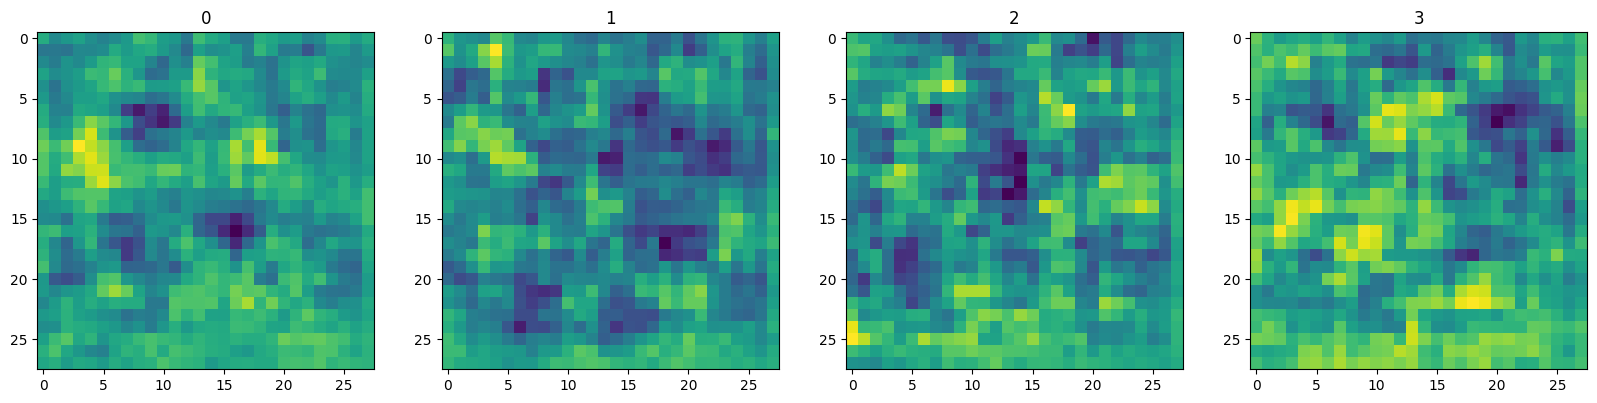

In [14]:
#Generate new fashion
img = generator.predict(np.random.randn(4,128,1))

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    #plot the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

Build Discriminator

In [15]:
def build_discriminator():
    model = Sequential()

    # Convolutional block 1
    model.add(Conv2D(32, 5, input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional block 2
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional block 3
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Convolutional block 4
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [16]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [17]:
img.shape

(28, 28, 1)

In [20]:
discriminator.predict(img)

1/1 [==============================] - 0s 465ms/step


array([[0.49613056],
       [0.4962008 ],
       [0.4964442 ],
       [0.49608177]], dtype=float32)

# **Construct Training Loop**

setup losses and optimizers

In [21]:
# adam is optimizer for both
from tensorflow.keras.optimizers import Adam
# binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [22]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

Build Subclassed Model

In [23]:
#importing the base model class to subclass
from tensorflow.keras.models import Model

In [25]:
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args, **kwargs):
    # Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    #create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
    # Pass through args and kwargs to base class
    super().compile(*args, **kwargs)
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss

  def train_step(self, batch):
    # Unpack batch
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Train Discriminator
    with tf.GradientTape() as d_tape:
      #pass the real and fake images to the discriminator model
      yhat_real = self.discriminator(real_images, training=True)
      yhat_fake = self.discriminator(fake_images, training=True)
      yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

      #create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      #add some noise to the output
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake], axis=0)

      #calculate loss - Binarycross
      total_d_loss = self.d_loss(y_realfake, yhat_realfake)

    #Apply Backpropagation - nn Learn
    #calculate gradients for discriminator
    dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    #apply gradients to discriminator
    self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    #Train Generator
    with tf.GradientTape() as g_tape:
      # Generate some fake
      gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

      # Create the predicted labels
      predicated_labels = self.discriminator(gen_images, training=False)

      # Calculate loss
      total_g_loss = self.g_loss(tf.zeros_like(predicated_labels), predicated_labels)

    #Apply Backpropagation - nn Learn
    #calculate gradients for generator
    ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    #apply gradients to generator
    self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

    return {"d_loss": total_d_loss, "g_loss": total_g_loss}



In [26]:
# create instance of subclasses model
fashgan = FashionGAN(generator, discriminator)
#compile the model
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

Build Callback

In [27]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self, epoch, logs=None):
    random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))


In [30]:
#recommended epoch = 2000
hist = fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
  6/469 [..............................] - ETA: 1:14 - d_loss: 0.7511 - g_loss: 0.6619

469/469 [==============================] - 77s 163ms/step - d_loss: 0.6911 - g_loss: 0.7216
Epoch 2/20
469/469 [==============================] - 76s 163ms/step - d_loss: 0.6854 - g_loss: 0.6789
Epoch 3/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6868 - g_loss: 0.5879
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.6873 - g_loss: 0.6125
Epoch 5/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.5780 - g_loss: 0.8390
Epoch 6/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.4573 - g_loss: 0.0666
Epoch 7/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.3463 - g_loss: 0.0197
Epoch 8/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.3093 - g_loss: 0.0152
Epoch 9/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.7273 - g_loss: 0.4696
Epoch 10/20
469/469 [==============================] - 76s 162ms/step - d_loss: 0.36

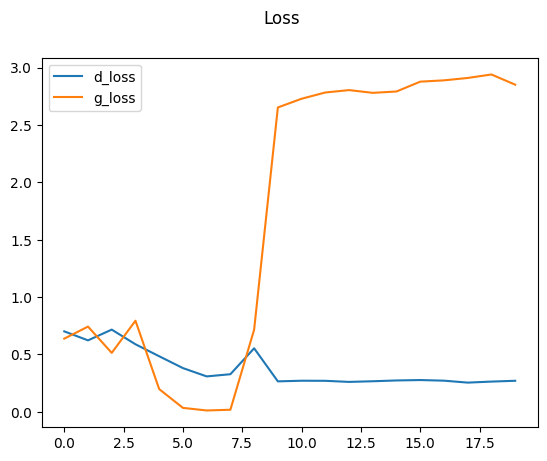

In [31]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 458ms/step


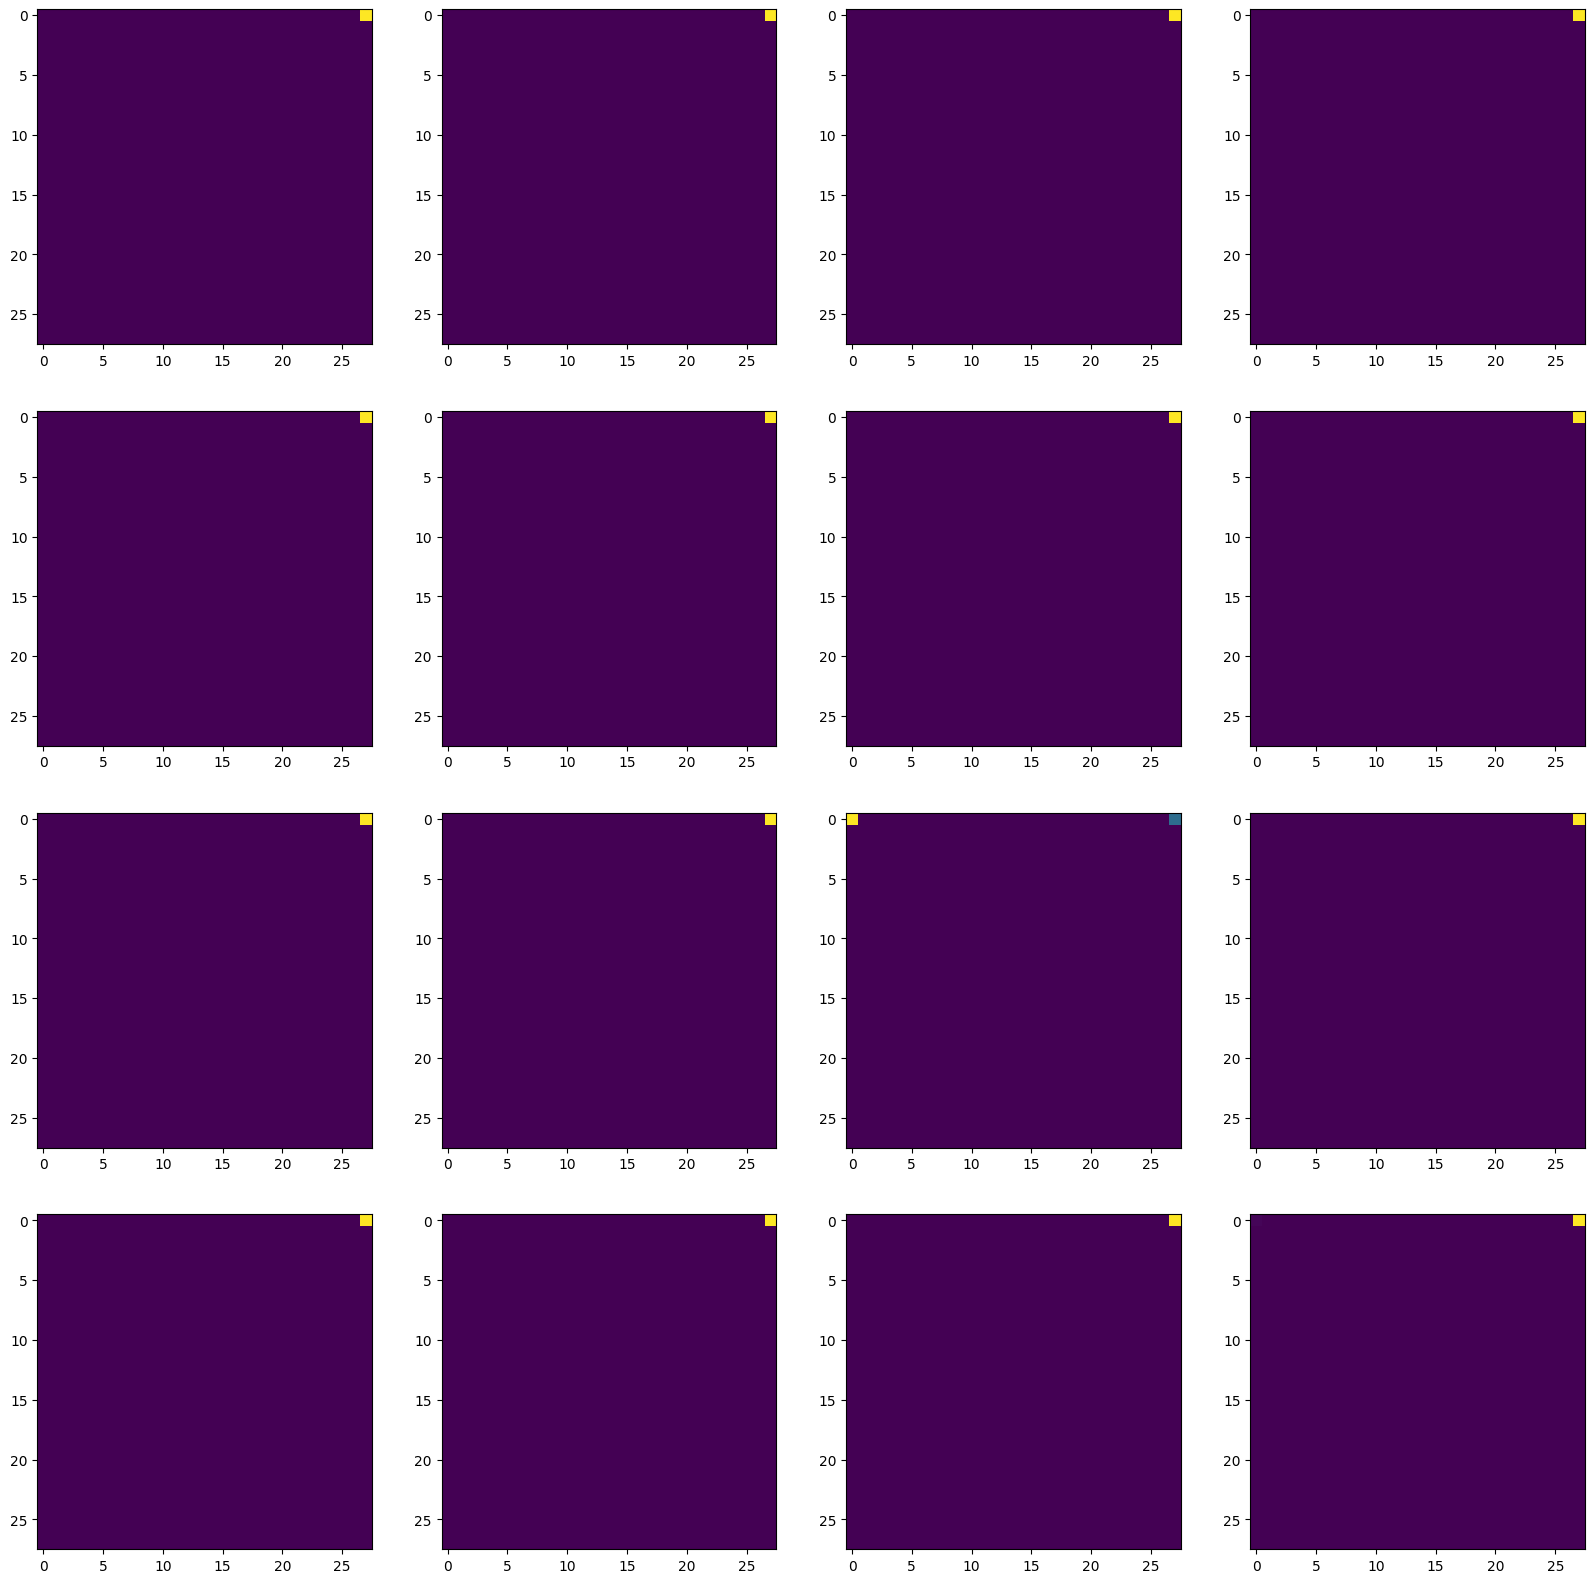

In [32]:
imgs = generator.predict(np.random.randn(16,128,1))

fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])


In [33]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
